In [481]:
from easydict import EasyDict as edict
import json, os
import torch

import pandas as pd
import numpy as np

from scipy.special import expit

import matplotlib.pyplot as plt

In [482]:
import sys
sys.path.append('/home/users/jschott/Chexpert/')
from model.classifier import Classifier
from data.dataset import ImageDataset  

## Laden der Testdaten

### CheXpert Datensatz hat einen besonderen Testdatensatz den wir hier laden (orignal)

In [483]:
datapath = '/work/projects/covid19_dv/raw_data/heavy_datasets/chexpert_stanford'

# place of the original validation data
original_validation_csv = pd.read_csv(os.path.join(datapath, 'CheXpert-v1.0/valid.csv'))

# Hier passen wir den Dateipfad an
original_validation_csv.Path = original_validation_csv.Path.apply(lambda x: os.path.join(datapath, x))

Write original test data file to disk

In [484]:
filename_original_testdata = '/home/users/jschott/chexpert_eval/test_orginal.csv'

dirname = os.path.dirname(filename_original_testdata)
if not os.path.exists(dirname):
    os.makedirs(dirname)
    
original_validation_csv.to_csv(filename_original_testdata, index=False)

### Wir haben einen **eigenen** Test- (Validierungs)datensatz gebaut, den wir hier laden

In [485]:
k = 10
filename_custom_testdata = f'/work/projects/covid19_dv/jessica_ba/config/valid_expB{k}.csv'
custom_validation_csv = pd.read_csv(filename_custom_testdata)

#### Load model

In [486]:
which_model = f'results_1-5_old_selection_70k_{k}'
#which_model = f'results_70k_{k}'
#which_model = f'results_1-5_young_selection_70k_{k}'
#which_model = f'results_1-5_male_70k_{k}'
#which_model = f'results_1-5_female_70k_{k}'
#evaluate_on = filename_original_testdata
evaluate_on = filename_custom_testdata

In [487]:
args = {
    'config': f'/work/projects/covid19_dv/jessica_ba/{which_model}/cfg.json',
    'model_weight': f'/work/projects/covid19_dv/jessica_ba/{which_model}/best1.ckpt', # "Path to the trained models"
    'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
     'num_workers': 8,             # "workers for each data loader"
    }  

args

{'config': '/work/projects/covid19_dv/jessica_ba/results_1-5_old_selection_70k_10/cfg.json',
 'model_weight': '/work/projects/covid19_dv/jessica_ba/results_1-5_old_selection_70k_10/best1.ckpt',
 'in_csv_path': '/work/projects/covid19_dv/jessica_ba/config/valid_expB10.csv',
 'num_workers': 8}

In [488]:
device = 'cuda:0'

In [489]:
# open config
with open(args['config']) as f:
    cfg = edict(json.load(f))

# create model
model = Classifier(cfg)
_ = model.to(device)

# load pretrained weights/parameter
# selbsttrainiertes Model
ckpt = torch.load(args['model_weight'], map_location='cpu')

model.load_state_dict(ckpt['state_dict'])


<All keys matched successfully>

### Create Dataloader
(zum laden des Datensatzes)

In [490]:
dataset = ImageDataset(args['in_csv_path'], cfg, mode='test')
dataloader_test = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg.dev_batch_size, 
    num_workers=args['num_workers'],
    drop_last=False, 
    shuffle=False
)

In [491]:
prediction_pathology = [
    'Cardiomegaly',
    'Edema',
    'Consolidation',
    'Atelectasis',
    'Pleural Effusion'   
]

## Vorhersagen durchfueheren

In [492]:
model.eval()

predictions = []
for image_batch, path in dataloader_test:
    with torch.no_grad():
        batch_prediction, _ = model(image_batch.to(device))
    batch_prediction = np.hstack([p.cpu().numpy() for p in batch_prediction])
    predictions.append(batch_prediction)
predictions = np.vstack(predictions)

In [493]:
# konvertieren der Modellausgabe zu Wahrscheinlichkeiten (sigmoid funktion) 
probabilities = expit(predictions)

# umwandeln in pandas dataframe
probabilities = pd.DataFrame(probabilities, columns=prediction_pathology)

#### Abspeichern der Predictions

In [494]:
if 'valid' in evaluate_on:
    probabilities.to_csv(os.path.dirname(args['model_weight'])+ '/test_custom_predictions.csv')
elif 'test_orginal' in evaluate_on:
    probabilities.to_csv(os.path.dirname(args['model_weight'])+ '/test_original_predictions.csv')

<AxesSubplot:>

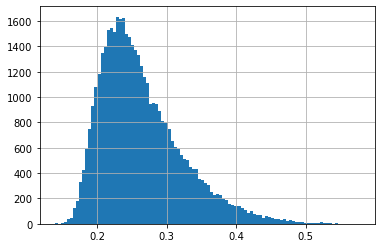

In [495]:
probabilities['Cardiomegaly'].hist(bins= 100)

### Evaluation des Modells

d.h. vergleich mit den "echten" Targets

In [496]:
import sklearn.metrics as skm

In [497]:
#evaluate_on = original_validation_csv.copy()
evaluate_on = custom_validation_csv.copy()

In [498]:
evaluate_on

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,PatientId
0,/work/projects/covid19_dv/raw_data/heavy_datas...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001
1,/work/projects/covid19_dv/raw_data/heavy_datas...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,patient00002
2,/work/projects/covid19_dv/raw_data/heavy_datas...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002
3,/work/projects/covid19_dv/raw_data/heavy_datas...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002
4,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,81,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,patient00008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43711,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,55,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,-1.0,0.0,1.0,NaN,1.0,NaN,patient64526
43712,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,77,Frontal,AP,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,patient64528
43713,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,81,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient64529
43714,/work/projects/covid19_dv/raw_data/heavy_datas...,Female,61,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,patient64536


#### Performance fuer eine Krankeit

In [499]:
col = 'Edema'

targets = evaluate_on[col].fillna(0)    # Spalte Atelektasis mit 0en Auffüllen
not_ignore = targets >= 0               # ignoriere alle Werte kleiner 0
print(f'{(~not_ignore).sum()} images neglected due to -1') # formatiert den String (die Variable in den geschweiften Klammern)

skm.roc_auc_score(targets[not_ignore], probabilities[col][not_ignore]) # berechne, wie gut das Modell vorhersagt für die jeweilige Krankheit mit den Werten >= 0
skm.log_loss(targets[not_ignore], probabilities[col][not_ignore]) # berechne, wie gut das Modell vorhersagt für die jeweilige Krankheit mit den Werten >= 0

2579 images neglected due to -1


0.5530470567464822

Text(0, 0.5, '# cases')

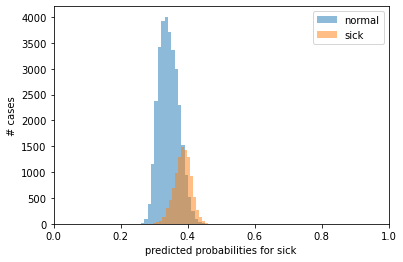

In [500]:
plt.hist(probabilities[col][not_ignore][targets[not_ignore] == 0], alpha=0.5, bins=20, label='normal')
plt.hist(probabilities[col][not_ignore][targets[not_ignore] == 1], alpha=0.5, bins=20, label='sick')
plt.legend()
plt.xlabel('predicted probabilities for sick')
plt.xlim([0, 1])
plt.ylabel('# cases')

In [501]:
prediction_pathology

['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']

In [502]:
probabilities[col][not_ignore].shape

(41137,)

#### Performance fuer alle 5 Krankheiten

In [503]:
diseases = []
diseases_log_loss= []

for i, col in enumerate(prediction_pathology):
    targets = evaluate_on[col].fillna(0)
    not_ignore = targets >= 0
    diseases.append(skm.roc_auc_score(targets[not_ignore], probabilities[col][not_ignore]))
    diseases_log_loss.append(skm.log_loss(targets[not_ignore], probabilities[col][not_ignore]))
    
print(diseases)
print(diseases_log_loss)

[0.8673832469169187, 0.8589002708341431, 0.7326597761624929, 0.6972090536424536, 0.8855782882648181]
[0.39442774263864916, 0.5530470567464822, 0.6538150006233584, 0.7482619841473642, 0.670989559414334]


#### Performance getrennt nach Geschlecht

In [504]:
selection_male = evaluate_on.Sex == 'Male'
selection_female = evaluate_on.Sex == 'Female'

In [505]:
diseases_m = []
diseases_f = []

for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[selection_male ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_m.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_male, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_female ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_f.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_female, col][not_ignore]))
        
print(diseases_m)
print(diseases_f)

[0.871218827937819, 0.8610766007243656, 0.7291675671142563, 0.7037713113930469, 0.8809858014126204]
[0.8608939455235063, 0.8555512121934404, 0.7380951792474092, 0.6860421106624564, 0.8925207522055276]


In [506]:
diseases_m_log_loss = []
diseases_f_log_loss = []

for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[selection_male ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_m_log_loss.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_male, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_female ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_f_log_loss.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_female, col][not_ignore]))
    
print(diseases_m_log_loss)
print(diseases_f_log_loss)

[0.39805617555873285, 0.5478244442480737, 0.654733906977432, 0.747061309740108, 0.6715890398725659]
[0.3889199553116639, 0.5610268414917923, 0.6524250617958868, 0.7500739050592095, 0.6700798621218108]


In [507]:
scores = pd.DataFrame([diseases, diseases_m, diseases_f], columns= prediction_pathology, index= ['all', 'male', 'female'])
scores_log_less = pd.DataFrame([diseases_log_loss, diseases_m_log_loss, diseases_f_log_loss], columns= prediction_pathology, index= ['all', 'male', 'female'])

In [508]:
import seaborn as sns

In [509]:
data = scores.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'AUC'})
data_log_loss = scores_log_less.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'LOG LOSS'})

<AxesSubplot:xlabel='diseases', ylabel='AUC'>

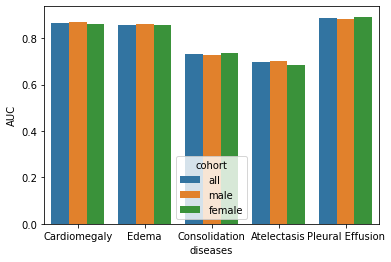

In [510]:
sns.barplot(data = data, x = 'diseases', hue='cohort', y='AUC')

<AxesSubplot:xlabel='diseases', ylabel='LOG LOSS'>

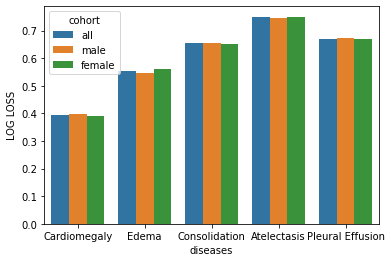

In [511]:
sns.barplot(data = data_log_loss, x = 'diseases', hue='cohort', y='LOG LOSS')

## Performance getrennt nach Altersgruppe

In [512]:
### trennen nach altersgruppe (schwierigkeit stufe 1)

In [513]:
selection_teens = (evaluate_on.Age >= 10) & (evaluate_on.Age < 20)
selection_twenties = (evaluate_on.Age >= 20) & (evaluate_on.Age < 30)
selection_thirties = (evaluate_on.Age >= 30) & (evaluate_on.Age < 40)
selection_fourties = (evaluate_on.Age >= 40) & (evaluate_on.Age < 50)
selection_fifties = (evaluate_on.Age >= 50) & (evaluate_on.Age < 60)
selection_sixties = (evaluate_on.Age >= 60) & (evaluate_on.Age < 70)
selection_seventies = (evaluate_on.Age >= 70) & (evaluate_on.Age < 80)
selection_eighties = (evaluate_on.Age >= 80) & (evaluate_on.Age < 90)
selection_nineties = (evaluate_on.Age >= 90)

In [514]:
evaluate_on.Age

0        68
1        87
2        83
3        83
4        81
         ..
43711    55
43712    77
43713    81
43714    61
43715    61
Name: Age, Length: 43716, dtype: int64

In [515]:
diseases_teens= []
diseases_twenties= []
diseases_thirties = []
diseases_fourties = []
diseases_fifties = []
diseases_sixties = []
diseases_seventies = []
diseases_eighties = []
diseases_nineties = []


for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[selection_teens ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_teens.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_teens, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_twenties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_twenties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_twenties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_thirties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_thirties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_thirties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fourties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fourties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_fourties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fifties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fifties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_fifties, col][not_ignore]))
        
    targets = evaluate_on.loc[selection_sixties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_sixties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_sixties, col][not_ignore]))
            
    targets = evaluate_on.loc[selection_seventies ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_seventies.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_seventies, col][not_ignore]))        
    
    targets = evaluate_on.loc[selection_eighties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_eighties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_eighties, col][not_ignore]))        
   
    targets = evaluate_on.loc[selection_nineties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_nineties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_nineties, col][not_ignore]))
    
print(diseases_teens)
print(diseases_twenties)
print(diseases_thirties)
print(diseases_fourties)
print(diseases_fifties)
print(diseases_sixties)
print(diseases_seventies)
print(diseases_eighties)
print(diseases_nineties)

[0.9583842083842085, 0.9145805884936319, 0.8399400042854083, 0.7387351778656126, 0.878430460495714]
[0.9167653674884085, 0.8587582829155863, 0.7479814156043093, 0.7642956987770525, 0.8816926238120811]
[0.897275584096188, 0.8772932929695805, 0.7736292488244639, 0.7363441502538786, 0.8929867811780531]
[0.8760943358684877, 0.857066227434972, 0.7604373468137254, 0.7375312135898666, 0.8765766929080883]
[0.8651402827308161, 0.8561493361911106, 0.7164196529826938, 0.7094291419948904, 0.8929975786473704]
[0.8529719644912704, 0.8567679052828472, 0.7400773312121237, 0.6628319024240613, 0.8904761631669931]
[0.8639457045860408, 0.8565397133575233, 0.7397177681562378, 0.6815728172519663, 0.8700169915635897]
[0.8286929090659717, 0.8394366757914773, 0.6775195934784686, 0.6575511081874305, 0.8758870926045457]
[0.7830441590980268, 0.8313324551010658, 0.6885624792368658, 0.6157847587195413, 0.8727920556350222]


In [516]:
scores_age = pd.DataFrame([diseases, diseases_teens, diseases_twenties, diseases_thirties, diseases_fourties, diseases_fifties, diseases_sixties, diseases_seventies, diseases_eighties, diseases_nineties], 
                          columns= prediction_pathology, 
                          index= ['all', 'teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties', 'nineties'])

In [517]:
data_age = scores_age.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'AUC'})

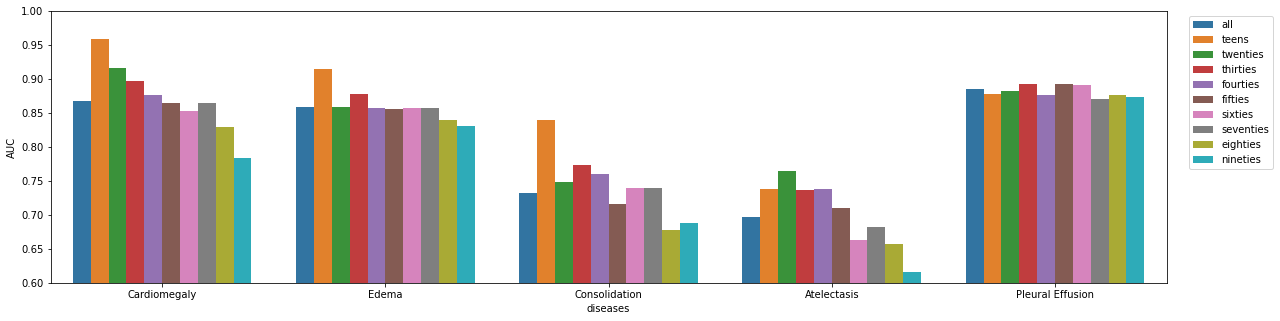

In [518]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.barplot(data = data_age, x = 'diseases', hue='cohort', y='AUC', ax=ax)
plt.ylim([0.6, 1])
plt.legend(loc= 'upper right', bbox_to_anchor=(1.1,1))

In [519]:
diseases_teens= []
diseases_twenties= []
diseases_thirties = []
diseases_fourties = []
diseases_fifties = []
diseases_sixties = []
diseases_seventies = []
diseases_eighties = []
diseases_nineties = []
diseases_all = []


for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[:,col].fillna(0)
    not_ignore = targets >= 0
    diseases_all.append(skm.log_loss(targets[not_ignore], probabilities.loc[:, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_teens ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_teens.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_teens, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_twenties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_twenties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_twenties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_thirties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_thirties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_thirties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fourties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fourties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_fourties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fifties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fifties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_fifties, col][not_ignore]))
        
    targets = evaluate_on.loc[selection_sixties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_sixties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_sixties, col][not_ignore]))
            
    targets = evaluate_on.loc[selection_seventies ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_seventies.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_seventies, col][not_ignore]))        
    
    targets = evaluate_on.loc[selection_eighties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_eighties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_eighties, col][not_ignore]))        
   
    targets = evaluate_on.loc[selection_nineties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_nineties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_nineties, col][not_ignore]))
    
print(diseases_teens)
print(diseases_twenties)
print(diseases_thirties)
print(diseases_fourties)
print(diseases_fifties)
print(diseases_sixties)
print(diseases_seventies)
print(diseases_eighties)
print(diseases_nineties)

[0.36223151921054364, 0.5019593064050029, 0.6408652443390388, 0.7522822154012132, 0.6911960908942354]
[0.3449082200407589, 0.4903022861232729, 0.6464221280003423, 0.7517799040198947, 0.6857154070329826]
[0.3540018201348888, 0.5085591838483625, 0.6482761650058309, 0.7502611761778231, 0.6825398894734913]
[0.35835709316099484, 0.5271892154668915, 0.648613689420865, 0.7462404639506904, 0.6777819592636615]
[0.37813127966253623, 0.5503896575294679, 0.6525291659387789, 0.7462277955735106, 0.6727967731681662]
[0.39467347011671927, 0.5474351282184852, 0.6547448461319476, 0.7478759327419765, 0.6663198056698121]
[0.409447736004353, 0.5788459825125714, 0.6579856720448441, 0.7455420837963692, 0.666169658677877]
[0.45583292326048497, 0.6066474294125805, 0.6602362784757918, 0.7523620832007191, 0.6614581257165956]
[0.510143101193122, 0.6028159149567778, 0.6600727379025019, 0.7558876855295497, 0.6663162920766205]


In [520]:
log_loss_scores_age = pd.DataFrame([diseases_all, diseases_teens, diseases_twenties, diseases_thirties, diseases_fourties, diseases_fifties, diseases_sixties, diseases_seventies, diseases_eighties, diseases_nineties], 
                          columns= prediction_pathology, 
                          index= ['all', 'teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties', 'nineties'])

In [521]:
data_age_loss = log_loss_scores_age.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'Log Loss'})

(0.2, 1.1)

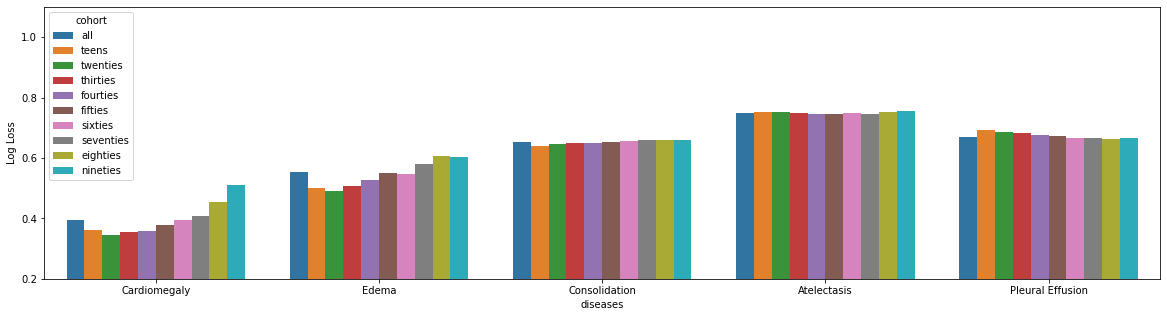

In [522]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.barplot(data = data_age_loss, x = 'diseases', hue='cohort', y='Log Loss', ax=ax)
plt.ylim([0.2, 1.1])

## Performance getrennt nach Geschlecht auf 100 zufaelligen sub-samples

In [523]:
### umbauen auf die neuen variablen (Varianz (100 Messungen))

In [524]:
rand_list_m = []
rand_list_f = []
rand_list_m_log_loss = []
rand_list_f_log_loss = []


for i in range(100):
    random_selection = np.random.rand(len(evaluate_on)) >= 0.2
    
    diseases_m = []
    diseases_f = []
    diseases_m_log_loss = []
    diseases_f_log_loss = []
    
    for i, col in enumerate(prediction_pathology):
        diseases_m.append(skm.roc_auc_score(evaluate_on.fillna(0).loc[selection_male&random_selection,col], probabilities.loc[selection_male&random_selection,col]))
        diseases_f.append(skm.roc_auc_score(evaluate_on.fillna(0).loc[selection_female&random_selection,col], probabilities.loc[selection_female&random_selection,col]))
        diseases_m_log_loss.append(skm.log_loss(evaluate_on.fillna(0).loc[selection_male&random_selection,col], probabilities.loc[selection_male&random_selection,col]))
        diseases_f_log_loss.append(skm.log_loss(evaluate_on.fillna(0).loc[selection_female&random_selection,col], probabilities.loc[selection_female&random_selection,col]))


    rand_list_m.append(diseases_m)
    rand_list_f.append(diseases_f)
    rand_list_m_log_loss.append(diseases_m_log_loss)
    rand_list_f_log_loss.append(diseases_f_log_loss)


ValueError: multi_class must be in ('ovo', 'ovr')

In [525]:
matrix_m = np.array(rand_list_m)
matrix_m_log_loss = np.array(rand_list_m_log_loss)
print(matrix_m.mean(axis=0))
print(matrix_m.std(axis=0))

nan
nan


/home/users/jschott/miniconda3/envs/nextry/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/users/jschott/miniconda3/envs/nextry/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/jschott/miniconda3/envs/nextry/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/users/jschott/miniconda3/envs/nextry/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/users/jschott/miniconda3/envs/nextry/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [526]:
matrix_f = np.array(rand_list_f)
matrix_f_log_loss = np.array(rand_list_f_log_loss)
print(matrix_f.mean(axis=0))
print(matrix_f.std(axis=0))

nan
nan


/home/users/jschott/miniconda3/envs/nextry/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until


In [527]:
df_m_auc = pd.DataFrame(matrix_m_log_loss, columns = prediction_pathology).stack()

ValueError: Empty data passed with indices specified.

In [528]:
df_m_log_loss = pd.DataFrame(matrix_m, columns = prediction_pathology).stack()

ValueError: Empty data passed with indices specified.

In [529]:
df_m_c = pd.concat([df_m_log_loss, df_m_auc], axis=1)       # axis = 1 bedeutet nebeneinander als Spalten (statt untereinander)

NameError: name 'df_m_log_loss' is not defined

In [530]:
df_m = df_m_c.reset_index()
df_m = df_m.rename(columns= {'level_0': 'round', 'level_1': 'pathology', 0: 'auc', 1: 'log loss'})

df_m['Sex'] = 'male'

NameError: name 'df_m_c' is not defined

In [531]:
df_m.head()

NameError: name 'df_m' is not defined

In [532]:
df_f_auc = pd.DataFrame(matrix_f_log_loss, columns = prediction_pathology).stack()
df_f_log_loss = pd.DataFrame(matrix_f, columns = prediction_pathology).stack()
df_f_c = pd.concat([df_f_log_loss, df_f_auc], axis=1)       # axis = 1 bedeutet nebeneinander als Spalten (statt untereinander)
df_f = df_f_c.reset_index()
df_f = df_f.rename(columns= {'level_0': 'round', 'level_1': 'pathology', 0: 'auc', 1: 'log loss'})
df_f['Sex'] = 'female'
df_f.head()

ValueError: Empty data passed with indices specified.

In [533]:
df = pd.concat([df_m, df_f])

NameError: name 'df_m' is not defined

In [534]:
sex=['female','male']

ax = sns.boxplot(data=df, x = 'pathology', y = 'auc',hue='Sex')
plt.ylim(0.5,1)

NameError: name 'df' is not defined

In [535]:
sex=['female','male']

ax = sns.boxplot(data=df, x = 'pathology', y = 'log loss',hue='Sex')
#plt.ylim(0.5,1)

NameError: name 'df' is not defined